In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from matplotlib import pyplot as plt
import seaborn as sns


from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_val_score,KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb


from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error


from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample

import pickle
import time





c:\Users\Piotr\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Preperations

In [2]:
def df_cleaning(df):
    '''initial preprocessing of insurance dataset'''
    print('1. All duplicated rows within dataset will be dropped. Found:', df.duplicated().sum(), 'duplicated rows.')
    df = df.drop_duplicates()
    print('2. All missing values within dataset will be replaced with 0. Found:', df.isna().sum().sum(), 'missing values. ')
    df = df.fillna(value=0)
    df = pd.get_dummies(df, drop_first=True)
    new_cols = [col for col in df.columns if col != 'charges'] + ['charges']
    df = df[new_cols]
    return df

In [3]:
def general_metrics(model,X_train,X_test,y_train,y_test,y_pred):
    r2,mae,mse,rmse=reg_metrics(y_test, y_pred)
    m_train=reg_test_train(model,X_train, y_train)
    m_test=reg_test_train(model,X_test, y_test)
    print('\nR2-train: {:.3f}\nR2-test: {:.3f} \nR2: {:.3f} \nMAE: {:.3f}\nMSE: {:.3f}'.format(m_train,m_test,r2,mae,mse))

def reg_metrics(y_true,y_pred):
    R2=r2_score(y_true, y_pred)
    MAE=mean_absolute_error(y_true, y_pred)
    MSE=mean_squared_error(y_true, y_pred)
    RMSE=mean_squared_error(y_true, y_pred, squared=False)
    # print('\nR2: {:.3f}\nMAE: {:.3f}\nMSE: {:.3f}'.format(R2,MAE,MSE))
    return R2,MAE,MSE,RMSE

def reg_test_train(model,X,y):
    R2=model.score(X,y)
    return R2


In [4]:
df = pd.read_csv('data/insurance.csv')
df=df_cleaning(df)
target=df.pop("charges")
data = df
random_state=1

1. All duplicated rows within dataset will be dropped. Found: 1 duplicated rows.
2. All missing values within dataset will be replaced with 0. Found: 0 missing values. 


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, target,test_size=0.33, random_state=random_state)

In [6]:
# X_tr, X_te, y_tr, y_te = train_test_split(data, target,test_size=0.33, random_state=random_state)

In [7]:
# from sklearn.metrics._plot.regression import PredictionErrorDisplay
# https://github.com/scikit-learn/scikit-learn/blob/7db5b6a98ac6ad0976a3364966e214926ca8098a/sklearn/metrics/_plot/regression.py
# \anaconda3\Lib\site-packages\sklearn\metrics\_plot

In [8]:
# XGB.fit(X_tr.values, y_tr.values)
# y_pr=XGB.predict(X_te.values)
# y_pr=pd.Series(y_pr)

In [9]:
# plt.scatter(y_te,y_pr)

In [10]:
# display = PredictionErrorDisplay(y_true=y_te.values, y_pred=y_pr.values)

In [11]:
# display.plot()
# # plt.show()

### Model's initial try

In [12]:
forest=RandomForestRegressor(max_depth=3, random_state=random_state)
tree = DecisionTreeRegressor(max_depth=3, random_state=random_state)
XGB = XGBRegressor(max_depth=3, objective='reg:squarederror', random_state=random_state)
dummy = DummyRegressor()
models=[forest,tree,XGB,dummy]

In [13]:
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

In [14]:
def run_model(model, X, y, cross_val):
    model_name = type(model).__name__
    rmse = np.sqrt(-cross_val_score(model, X, y, cv=cross_val, scoring='neg_root_mean_squared_error'))
    r2 = cross_val_score(model, X, y, cv=cross_val, scoring='r2')
    metrics=pd.DataFrame([[model_name,np.mean(rmse),100*np.mean(r2)]],columns=['model','RMSE','R2 [%]'])
    # print(dd)
    # print("{} rmse: {:.4f}, r2: {:.1f}%".format(model_name, np.mean(rmse), 100*np.mean(r2)))
    return metrics

In [15]:
column_names=['model','RMSE','R2 [%]']
df_results=pd.DataFrame(columns=column_names)
for model in models:
    result=run_model(model, X_train.values, y_train.values, kf)
    df_results=pd.concat([df_results,result],ignore_index=True)
df_results.style.format(precision=2)
    

,model,RMSE,R2 [%]
0,RandomForestRegressor,68.32,85.32
1,DecisionTreeRegressor,69.29,84.52
2,XGBRegressor,70.07,83.63
3,DummyRegressor,111.18,-0.86


In [16]:
# a=run_model(model, X_train.values, y_train.values, kf)
col_names=['model','RMSE','R2']
a=run_model(model, X_train.values, y_train.values, kf)
ept=pd.DataFrame(columns =col_names)
ept=pd.concat([ept,a])
ept.style.format(precision=2)


,model,RMSE,R2,R2 [%]
0,DummyRegressor,111.18,nan,-0.86


In [17]:
for model in models:
    model.fit(X_train.values, y_train.values)

In [18]:
import scikitplot as skplt
def plot_feature_importances(model, feat_list, ax):

    model_name = type(model).__name__
    skplt.estimators.plot_feature_importances(model, feature_names=data[feat_list].columns,
                                            title=f'{model_name} feature importances', ax=ax)
    plt.xticks(rotation=90)

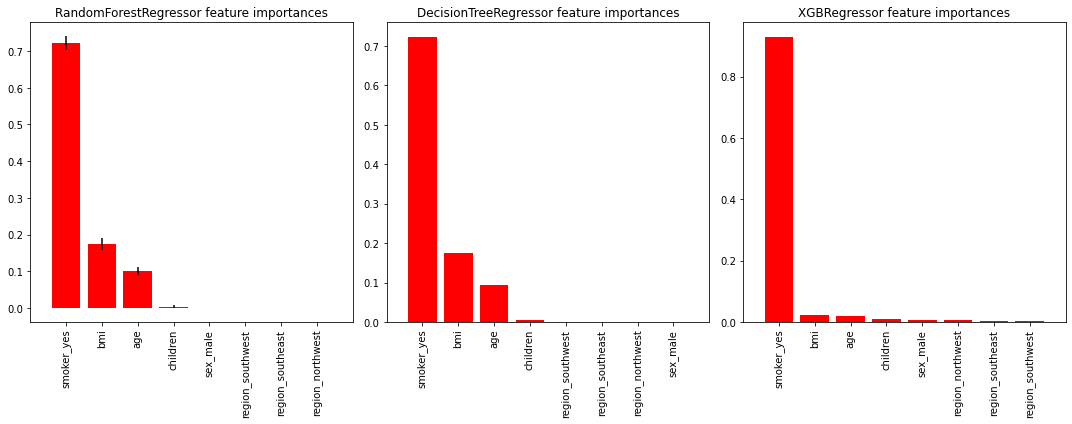

In [19]:
fig=plt.figure(figsize=(15,6))
for i, model in enumerate(models[0:3]):
    ax=fig.add_subplot(1,3,i+1)
    plot_feature_importances(model, X_train.columns, ax=ax)
fig.tight_layout()
plt.show()

In [20]:
column_names=['model','R2-train','R2-test','MAE','MSE','RMSE']
df_results=pd.DataFrame(columns=column_names)
for model in models:
    y_pred = model.predict(X_test.values)
    R2,MAE,MSE,RMSE=reg_metrics(y_test, y_pred)
    result=pd.DataFrame([[type(model).__name__,model.score(X_train.values, y_train.values),model.score(X_test.values, y_test.values),MAE,MSE,RMSE]],columns=column_names)
    df_results=pd.concat([df_results,result],ignore_index=True)
    # print('{} \nR2-train: {:.3f}\nR2-test: {:.3f}\n'.format(type(model).__name__,model.score(X_train.values, y_train.values),model.score(X_test.values, y_test.values)))
df_results.style.format(precision=3)
    
    

,model,R2-train,R2-test,MAE,MSE,RMSE
0,RandomForestRegressor,0.866,0.849,2565.468,19838732.725,4454.069
1,DecisionTreeRegressor,0.860,0.845,2720.206,20326323.274,4508.472
2,XGBRegressor,0.937,0.839,2614.085,21148757.869,4598.778
3,DummyRegressor,0.000,-0.018,8872.169,133836123.666,11568.756


### Models's check - HyperOPT

In [21]:
multi_space=[
    hp.choice('regression_model', [
    {
        'model': RandomForestRegressor,
        'params':{
            'n_estimators': hp.choice('n_estimators', np.arange(1, 100, 1)),
            'max_depth': hp.choice('max_depth', np.arange(2, 50, 1)),
            'min_samples_split':hp.choice('min_samples_split',np.arange(2,100,2)),
            'min_samples_leaf':hp.choice('min_samples_leaf',np.arange(2,100,5)),
            'max_leaf_nodes':hp.choice('max_leaf_nodes',np.arange(2,100,2)),
            'random_state':random_state
        }
    }]),
    hp.choice('regression_model', [
    {
        'model': DecisionTreeRegressor,
        'params':{
            'max_depth': hp.choice('max_depth', np.arange(2, 50, 1)),
            'min_samples_split':hp.choice('min_samples_split',np.arange(2,100,1)),
            'min_samples_leaf':hp.choice('min_samples_leaf',np.arange(2,100,1)),
            'max_leaf_nodes':hp.choice('max_leaf_nodes',np.arange(2,100,1)),
            'random_state':random_state
        }
    }]),
    hp.choice('regression_model', [
        {
        'model': XGBRegressor,
        'params': {
            'xgb.objective':'reg:squarederror',
            'max_depth':hp.choice('xgb.max_depth', np.arange(3, 40, 1)),
            'xgb.learning_rate':0.01,
            'xgb.gamma':0.6,
            # 'xgb.subsample':0.8378537709017343,
            'xgb.subsample':0.6,
            'xgb.colsample_bytree':0.85,
            # 'max_depth' : hp.choice('xgb.max_depth',np.arange(5, 30, 1)),
            # 'learning_rate' : hp.choice('xgb.learning_rate',np.arange(0.01, 0.5, 0.01)),
            'n_estimators' : hp.choice('xgb.n_estimators',np.arange(2, 500, 1)),
            'reg_lambda' : hp.uniform ('xgb.reg_lambda', 0,1),
            'reg_alpha' : hp.uniform ('xgb.reg_alpha', 0,2),
            'random_state':random_state
        }
    }])

]

In [22]:
def objective(args):
    clf=args['model']()
    score = cross_val_score(clf,X_train, y_train, cv=5, n_jobs=-1, error_score=0.99)    
    return {'loss': np.mean(score), 'status': STATUS_OK}

In [23]:
def results(space_it):
    best_params = space_eval(space_it['params'], best)
    clf=space_eval(space_it['model'],best)()
    m_name=type(space_eval(space_it['model'],best)()).__name__
    if m_name == 'XGBClassifier':
        model = clf.fit(X_train.values, y_train.values,eval_metric = 'rmse',verbose=False,early_stopping_rounds=10,eval_set=[(X_test.values, y_test.values)])
    else:
        model = clf.fit(X_train.values, y_train.values)
    y_pred_train = model.predict(X_train.values)
    y_pred_test = model.predict(X_test.values)
    # general_metrics(model,X_train,X_test,y_train,y_test,y_pred_test)
    R2,MAE,MSE,RMSE=reg_metrics(y_test, y_pred_test)
    metrics=pd.DataFrame([[R2,MAE,MSE,RMSE]],columns=['R2','MAE','MSE','RMSE'])
    rmse=mean_squared_error(y_test, y_pred_test, squared=False)
    return m_name,y_test,y_pred_test,rmse,metrics

In [24]:
def Hopt_run(space_it,itteration):
    trials = Trials()
    best = fmin(
    fn=objective,
    space = space_it, 
    algo=tpe.suggest,
    max_evals=itteration, 
    trials=trials)
    print("Best: {}".format(best))
    return best,trials
    

#### Run all models

In [25]:
res={}
column_names=columns=['model','R2','MAE','MSE','RMSE']
df_results=pd.DataFrame(columns=column_names)
x=0
for i in multi_space:
    best,trials=Hopt_run(multi_space[x],50)
    model_name,test,pred, rmse,metrics=results(multi_space[x])
    res[model_name]=[test,pred]
    metrics['model']=model_name
    df_results=pd.concat([df_results,metrics],ignore_index=True)
    # traials_losses.plot()
    print('Model name: {}'.format(model_name))
    # print('\nModel name: {}\nrmse: {}'.format(model_name,rmse))
    x+=1
df_results.style.format(precision=3)



100%|██████████| 50/50 [00:24<00:00,  2.06trial/s, best loss: 0.8351181281477498]
Best: {'max_depth': 26, 'max_leaf_nodes': 22, 'min_samples_leaf': 6, 'min_samples_split': 8, 'n_estimators': 88, 'regression_model': 0}
Model name: RandomForestRegressor
100%|██████████| 50/50 [00:02<00:00, 18.67trial/s, best loss: 0.6795572320680343]
Best: {'max_depth': 18, 'max_leaf_nodes': 91, 'min_samples_leaf': 34, 'min_samples_split': 30, 'regression_model': 0}
Model name: DecisionTreeRegressor
100%|██████████| 50/50 [00:20<00:00,  2.48trial/s, best loss: 0.8083749283692885]
Best: {'regression_model': 0, 'xgb.max_depth': 3, 'xgb.n_estimators': 122, 'xgb.reg_alpha': 1.0834377246629032, 'xgb.reg_lambda': 0.3083817768291299}
Model name: XGBRegressor


,model,R2,MAE,MSE,RMSE
0,RandomForestRegressor,0.825,2675.532,23049199.257,4800.958
1,DecisionTreeRegressor,0.596,3640.959,53181688.924,7292.578
2,XGBRegressor,0.813,2852.896,24583926.171,4958.218


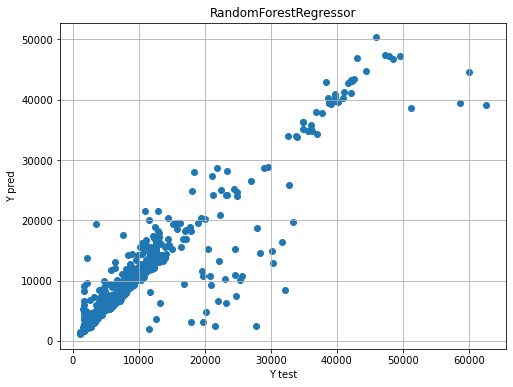

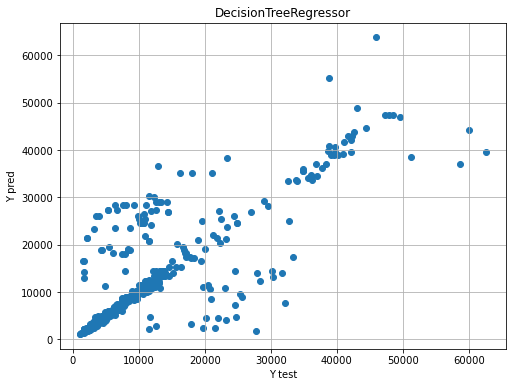

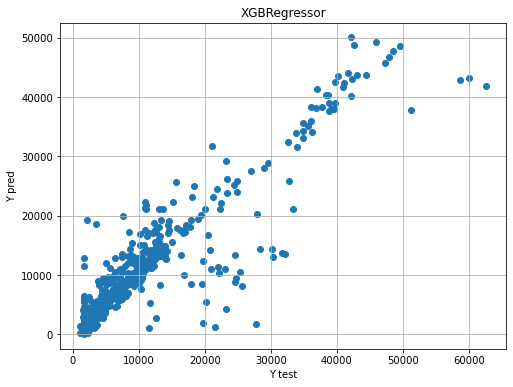

In [26]:
    for k in res.keys():
        mod=k
        plt.figure(figsize=(8,6))
        plt.scatter(res[mod][0],res[mod][1])
        plt.title(mod)
        plt.xlabel('Y test')
        plt.ylabel('Y pred')
        plt.grid()
        plt.show;

In [27]:
df_new=X_test.copy()
df_new['charges']=res['XGBRegressor'][0]
df_new['prediction']=res['XGBRegressor'][1]
df_new['region']=np.zeros(len(df_new)).astype('object')
# df_new['region']=df_new['region'].astype('object')

In [28]:

for index, row in df_new.iterrows():
    if df_new.loc[index, 'region_northwest'] == 1:
        df_new.loc[index, 'region'] = 'NW'
    elif df_new.loc[index, 'region_southeast'] == 1:
        df_new.loc[index, 'region'] = 'SE'
    elif df_new.loc[index, 'region_southwest'] == 1:
        df_new.loc[index, 'region'] = 'SW'
    else:
        df_new.loc[index, 'region'] = 'NE'

<AxesSubplot:xlabel='charges', ylabel='prediction'>

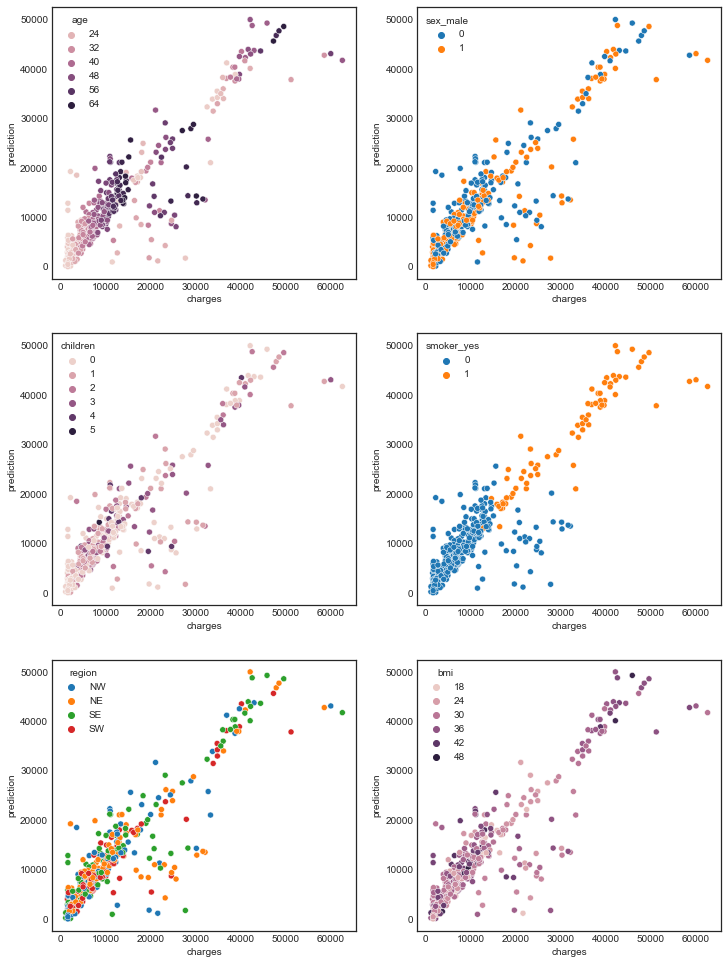

In [29]:
plt.figure(figsize = (12, 17))
plt.style.use('seaborn-white')
plt.subplot(321)
sns.scatterplot(x="charges", y="prediction",hue="age", data=df_new)
plt.subplot(322)
sns.scatterplot(x="charges", y="prediction",hue="sex_male", data=df_new)
plt.subplot(323)
sns.scatterplot(x="charges", y="prediction",hue="children", data=df_new)
plt.subplot(324)
sns.scatterplot(x="charges", y="prediction",hue="smoker_yes", data=df_new)
plt.subplot(325)
sns.scatterplot(x="charges", y="prediction",hue="region", data=df_new)
plt.subplot(326)
sns.scatterplot(x="charges", y="prediction",hue="bmi", data=df_new)

In [30]:
# traials_losses=pd.DataFrame(trials.losses())
# traials_losses.plot()